## Classifying between 6 and 4
## Using amplitude encoding (28x28)

In [1]:
import pennylane as qml
import tensorflow as tf
#import sklearn.datasets
#from sklearn.datasets import fetch_openml

import numpy as np

from matplotlib import pyplot as plt

tf.keras.backend.set_floatx('float64')

from silence_tensorflow import silence_tensorflow
silence_tensorflow()  # this stops tensorflow complaining about converting from complex to float!

from datetime import datetime

## Load and reduce the data

Load the MNIST data and check number of training and test examples

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0  # add colour dimension

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


Create a function to filter out only 0 and 2

In [3]:
def filter_64(x, y):
    keep = (y == 6) | (y == 4)
    x, y = x[keep], y[keep]
    y = y == 0
    return x,y

In [4]:
x_train, y_train = filter_64(x_train, y_train)
x_test, y_test = filter_64(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 11760
Number of filtered test examples: 1940


Plot the original images

In [5]:
i = 0

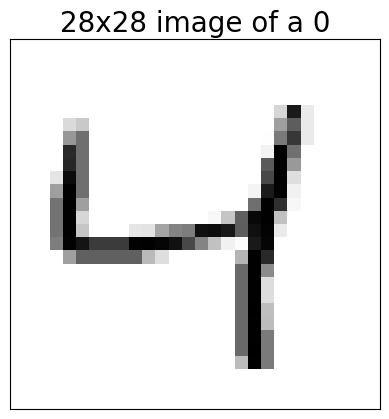

In [6]:
i += 1
plt.imshow(x_train[0, :, :, 0], cmap='Greys')
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.title("28x28 image of a 0", fontsize=20)
# save to file as pdf
plt.savefig('28x28_MNIST_0.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

Flatten the images to [784]

In [7]:
x_train_flatten = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
x_test_flatten = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])
x_train_flatten.shape, x_test_flatten.shape

((11760, 784), (1940, 784))

## Set up the Quantum Neural Network

Create quantum circuit using pennylane qnode, then conver this to a Keras layer to make a Keras model

In [8]:
def build_qnn_model(num_of_layers):
    print(f"{80*'*'}")
    print(f"Building QNN model with {num_of_layers} layer(s)")
    print(f"{80*'*'}")
    print()
    n_qubits = int(np.ceil(np.log2(x_train_flatten.shape[-1])))
    n_layers = num_of_layers

    dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev, interface="tf")
    def qnode(inputs, weights):
        
        qml.AmplitudeEmbedding(features=inputs, wires=range(n_qubits), pad_with=0., normalize=True)

        for jj in range(n_layers):
            for ii in range(n_qubits-1):
                qml.RZ(weights[jj,2*ii,0], wires=0)
                qml.RY(weights[jj,2*ii,1], wires=0)
                qml.RZ(weights[jj,2*ii,2], wires=0)

                qml.RZ(weights[jj,2*ii+1,0], wires=ii+1)
                qml.RY(weights[jj,2*ii+1,1], wires=ii+1)
                qml.RZ(weights[jj,2*ii+1,2], wires=ii+1)

                #qml.U3(*list(weights[jj,2*ii,:]), wires=0)
                #qml.U3(*list(weights[jj,2*ii+1,:]), wires=ii+1)
                qml.CNOT(wires=[ii+1,0])
                
            qml.RZ(weights[jj,2*(n_qubits-1),0], wires=0)
            qml.RY(weights[jj,2*(n_qubits-1),1], wires=0)
            qml.RZ(weights[jj,2*(n_qubits-1),2], wires=0)

        return qml.expval(qml.PauliZ(0))

    weight_shapes = {"weights": (n_layers, 2*(n_qubits-1)+1, 3) }

    qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=1, name="quantumLayer")
    inputs = tf.keras.Input(shape=(x_train_flatten.shape[-1],), name="inputs")
    outputs = qlayer(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="QNN")

    y_train_hinge = 2.0*y_train-1.0
    y_test_hinge = 2.0*y_test-1.0

    def hinge_accuracy(y_true, y_pred):
        y_true = tf.squeeze(y_true) > 0.0
        y_pred = tf.squeeze(y_pred) > 0.0
        result = tf.cast(y_true == y_pred, tf.float32)

        return tf.reduce_mean(result)
    
    model.compile(
        loss=tf.keras.losses.Hinge(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[hinge_accuracy])
    
    print(model.summary())

    EPOCHS = 20
    BATCH_SIZE = 32

    NUM_EXAMPLES = 512 
    print(f"x shape = {x_train_flatten.shape}")

    x_train_sub = x_train_flatten[:NUM_EXAMPLES]
    y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

    print(f"x train shape = {x_train_sub.shape}")

    x_test_sub = x_test_flatten[:,:]
    y_test_sub = y_test[:]

    print(f"x test shape = {x_test_sub.shape}")

    start_time = datetime.now()

    qnn_history = model.fit(
        x_train_sub, y_train_hinge_sub,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        verbose=1)#,
        #validation_data=(x_test_sub, y_test_sub))

    model_training_time = datetime.now() - start_time

    qnn_results = model.evaluate(x_test_sub, y_test_sub)

    print()

    return qnn_history, model_training_time, qnn_results

In [9]:
qnn_list = []

for i in range(1, 4):
    qnn_history, model_training_time, qnn_results = build_qnn_model(i)
    qnn_list.append([i, qnn_history, model_training_time, qnn_results])

********************************************************************************
Building QNN model with 1 layer(s)
********************************************************************************

Model: "QNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 784)]             0         
                                                                 
 quantumLayer (KerasLayer)   (None, 1)                 57        
                                                                 
Total params: 57 (456.00 Byte)
Trainable params: 57 (456.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
x shape = (11760, 784)
x train shape = (512, 784)
x test shape = (1940, 784)
Epoch 1/20
16/16 [==============================] - 6s 353ms/step - loss: 1.0057 - hinge_accuracy: 0.3945
Epoch 2/20
16/16 [===================

## Plot the results!

In [10]:
qnn_histories = {}

for [i, qnn_history, model_training_time, qnn_results] in qnn_list:
    print(f"Training time for {i}-layer QNN: {model_training_time}")
    print()
    if i not in qnn_histories:
        qnn_histories[i] = []
    qnn_histories[i].append(qnn_history)

Training time for 1-layer QNN: 0:01:50.811503

Training time for 2-layer QNN: 0:03:32.255527

Training time for 3-layer QNN: 0:05:14.626301



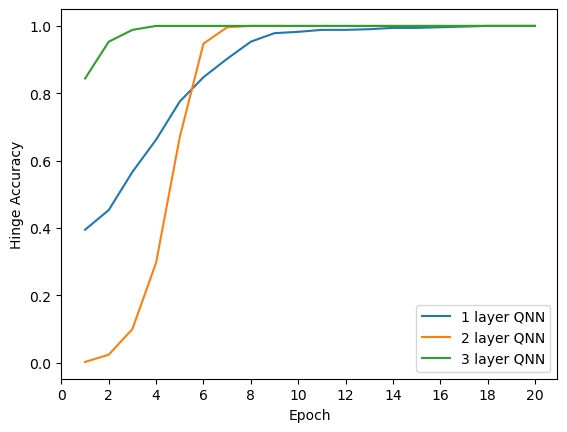

In [11]:
# plot the hinge accuracy for the qnn history for both 1 and 2 layer on the same axes
for n in qnn_histories.keys():
    plt.plot(np.arange(1,21), qnn_histories[n][0].history["hinge_accuracy"], label=f"{n} layer QNN")

plt.xlabel("Epoch")
plt.ylabel("Hinge Accuracy")
plt.legend()
# modify x_ticks to also include 20
plt.xticks(np.arange(0, 21, 2))
# save as pdf with tight layout and no padding
#plt.savefig("qnn_hinge_accuracy.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

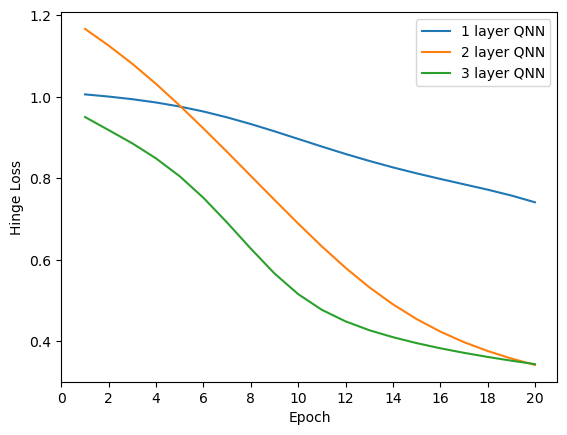

In [12]:
# plot the hinge accuracy for the loss for both 1 and 2 layer on the same axes
for n in qnn_histories.keys():
    plt.plot(np.arange(1,21), qnn_histories[n][0].history["loss"], label=f"{n} layer QNN")

plt.xlabel("Epoch")
plt.ylabel("Hinge Loss")
plt.legend()
# modify x_ticks to also include 20
plt.xticks(np.arange(0, 21, 2))
# save as pdf with tight layout and no padding
#plt.savefig("qnn_hinge_loss.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

In [13]:
import pickle

timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
with open(f'qnn_histories_{timestamp}.pkl', 'wb') as f:
    pickle.dump(qnn_histories, f)

print(f"Saved qnn_histories to qnn_histories_{timestamp}.pkl")

Saved qnn_histories to qnn_histories_20250322180000.pkl
